In [1]:
import numpy as np
import glob
import matplotlib.pyplot as plt
import cv2
import pandas as pd
import seaborn as sns
import pickle
from skimage import measure, segmentation, feature
from vis_utils import load_volume, VolumeVisualizer, ColorMapVisualizer
from scipy.ndimage import zoom
from skimage.morphology import skeletonize, skeletonize_3d, binary_dilation
from skimage import filters, morphology
from scipy.ndimage.filters import convolve, correlate
from scipy import signal
from skimage.filters import frangi, sato
from skimage.draw import line_nd
from PIL import Image
from queue import PriorityQueue

In [2]:
TREE_NAME = 'P12'

## Loading DAG with stats

In [22]:
class Node:
    def __init__(self, coords):
        self.coords = coords
        self.edges = []
        self.data = {}
            
    def add_edge(self, edge):
        self.edges.append(edge)
        
    def get_neighbours(self):
        return [e.node_a if e.node_a.coords != self.coords else e.node_b for e in self.edges]
    
    def copy_without_edges(self):
        copied_node = Node(self.coords)
        copied_node.data = self.data
        return copied_node
    
    def __setitem__(self, key, value):
        self.data[key] = value
    
    def __getitem__(self, key):
        return self.data[key]
    
    def __hash__(self):
        return hash(self.coords)
    
    def __repr__(self):
        return f'Node {str(self.coords)}'
       
        
class Edge:
    def __init__(self, node_a, node_b):
        self.node_a = node_a
        self.node_b = node_b
        self.data = {}
        
    def __setitem__(self, key, value):
        self.data[key] = value
    
    def __getitem__(self, key):
        return self.data[key]
    
    def __repr__(self):
        return f'Edge {self.node_a.coords} -> {self.node_b.coords}'

    
class DAG:
    def __init__(self, root, volume_shape):
        self.root = root
        self.nodes = get_nodes_with_dfs(root)
        self.edges = get_edges_with_dfs(root)
        self.volume_shape = volume_shape
        self.data = {}
    
    def __setitem__(self, key, value):
        self.data[key] = value
    
    def __getitem__(self, key):
        return self.data[key]

def save_dag(dag, filename):
    with open(filename, 'wb') as output:
        pickle.dump(dag, output)
        

def load_dag(filename):
    with open(filename, 'rb') as input_:
        dag = pickle.load(input_)
        return dag

In [23]:
source_dir = './data/'
dag = load_dag(source_dir + TREE_NAME + '/dag-with-stats.pkl')

## Utility visualisation functions

In [5]:
def visualize_addition(base, base_with_addition):
    base = (base.copy() > 0).astype(np.uint8)
    addition = (base_with_addition > 0).astype(np.uint8)
    addition[base == 1] = 0
    ColorMapVisualizer(base + addition * 4).visualize()
    
def visualize_lsd(lsd_mask):
    ColorMapVisualizer(lsd_mask.astype(np.uint8)).visualize()
    
def visualize_gradient(lsd_mask):
    ColorMapVisualizer(lsd_mask.astype(np.uint8)).visualize(gradient=True)
    
def visualize_mask_bin(mask):
    VolumeVisualizer((mask > 0).astype(np.uint8), binary=True).visualize()
    
def visualize_mask_non_bin(mask):
    VolumeVisualizer((mask > 0).astype(np.uint8) * 255, binary=False).visualize()
    
def visualize_skeleton(mask, visualize_mask=True, visualize_both_versions=False):
    skeleton = skeletonize((mask > 0).astype(np.uint8))
    if not visualize_mask or visualize_both_versions:
        VolumeVisualizer(skeleton, binary=True).visualize()
    if visualize_mask or visualize_both_versions:
        skeleton = skeleton.astype(np.uint8) * 4
        mask = (mask > 0).astype(np.uint8) * 3
        mask[skeleton != 0] = 0
        ColorMapVisualizer(skeleton + mask).visualize()

def visualize_ultimate(lsd, base_mask):
    visualize_lsd(lsd)
    visualize_mask_non_bin(lsd)
    visualize_addition(base_mask, lsd)
    visualize_skeleton(lsd, visualize_mask=True)

## DAG visualization

In [36]:
def spherical_kernel(outer_radius, thickness=1, filled=True):    
    outer_sphere = morphology.ball(radius=outer_radius)
    if filled:
        return outer_sphere
    
    thickness = min(thickness, outer_radius)
    
    inner_radius = outer_radius - thickness
    inner_sphere = morphology.ball(radius=inner_radius)
    
    begin = outer_radius - inner_radius
    end = begin + inner_sphere.shape[0]
    outer_sphere[begin:end, begin:end, begin:end] -= inner_sphere
    return outer_sphere


def print_kernels(image, nodes, value):
    image = image.copy()
    max_kernel_radius = int(max([node['thiccness'] for node in nodes]))
    kernels = [spherical_kernel(radius) for radius in range(max_kernel_radius + 1)]
    
    padded_image = np.pad(image, max_kernel_radius)
    kernels_image = np.zeros(padded_image.shape)
    
    for node in nodes:
        x, y, z = (coord + max_kernel_radius for coord in node.coords)
        kernel_radius = int(node['thiccness'])
        kernel = kernels[kernel_radius]
        
        mask_slice = kernels_image[
            x-kernel_radius:x+kernel_radius + 1,
            y-kernel_radius:y+kernel_radius + 1,
            z-kernel_radius:z+kernel_radius + 1
        ]
        
        mask_slice[:] = np.logical_or(mask_slice, kernel)
            
    kernels_image = kernels_image[
        max_kernel_radius:-max_kernel_radius,
        max_kernel_radius:-max_kernel_radius,
        max_kernel_radius:-max_kernel_radius
    ]
    
    image[kernels_image == 1] = value
    return image


def draw_nodes(image, nodes, value=2):
    nodes_image = print_kernels(image, nodes, value)
    return nodes_image

    
def draw_edges(image, edges, value='mean_thiccness', interpolate=True):
    image = image.copy()

    for i, edge in enumerate(edges):
        if type(value) == str:
            fill_value = edge[value]
        else:
            fill_value = value
        
        if interpolate:
            image[line_nd(edge.node_a.coords, edge.node_b.coords)] = fill_value
        else:
            for v in edge['voxels']:
                image[tuple(v)] = fill_value
    return image


def draw_central_line(image, dag):
    image_with_edges = draw_edges(image, dag.edges, value=1, interpolate=False)
    for n in dag.nodes:
        for v in n['voxels']:
            image_with_edges[tuple(v)] = 1
    return image_with_edges

In [26]:
visualization = np.zeros(dag.volume_shape)
visualization = draw_nodes(visualization, dag.nodes, 25)
visualization = draw_edges(visualization, dag.edges, value='thiccness')
visualize_gradient(visualization)

# Parameters presentation

## Vessels length

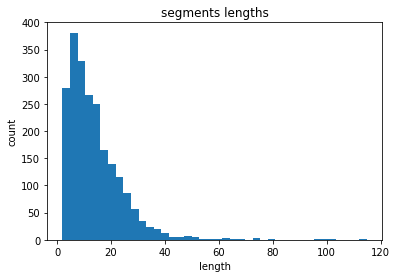

In [9]:
lengths = [edge['length'] for edge in dag.edges]
plt.title('segments lengths')
plt.hist(lengths, bins=40)

plt.xlabel('length')
plt.ylabel('count')
plt.show()

In [10]:
print("Total vessels length is", sum(lengths))

Total vessels length is 31085.600872727333


In [14]:
print("Mean vessels length is", np.mean(lengths))

Mean vessels length is 14.116984955825302


## Segments diameters

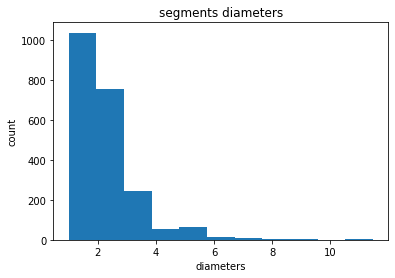

In [15]:
diameters = [edge['mean_thiccness'] for edge in dag.edges]
plt.title('segments diameters')
plt.hist(diameters, bins=int(np.max(diameters)))
plt.xlabel('diameters')
plt.ylabel('count')
plt.show()

In [16]:
print("Mean vessels diameter is", np.mean(diameters))

Mean vessels diameter is 2.090952295305367


## Nodes degrees counts

In [25]:
print(np.unique([len(n.edges) for n in dag.nodes], return_counts=True))
print("Total number of branchings is", dag['branching_points'], 'or', len(dag.nodes), 'including leaves')

(array([0, 1, 2, 3, 4, 5]), array([1171,    1,  907,  110,   13,    1]))
Total number of branchings is 1031 or 2203 including leaves


## Bifurcations angles

In [31]:
def draw_directions(image, edges, start_value=2, end_value=3, length=10):
    image = image.copy()

    for edge in edges:
        start_point = edge.node_a['centroid']
        end_point = start_point + length * edge['start_direction']
        end_point = np.maximum([0, 0, 0], end_point)
        end_point = np.minimum(np.array(image.shape) - 1, end_point)
        image[line_nd(start_point, end_point)] = start_value
        
        start_point = edge.node_b['centroid']
        end_point = start_point + length * edge['end_direction']
        end_point = np.maximum([0, 0, 0], end_point)
        end_point = np.minimum(np.array(image.shape) - 1, end_point)
        image[line_nd(start_point, end_point)] = end_value
        
    return image

img = np.zeros(dag.volume_shape)
img = draw_edges(img, dag.edges, value=2, interpolate=False)
img = draw_directions(img, dag.edges, start_value=4, end_value=3, length=15)
visualize_lsd(img)

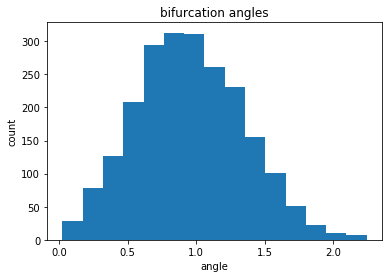

57.29577951308232

In [28]:
angles = [edge['relative_angle'] for edge in dag.edges[1:]]
plt.title('bifurcation angles')
plt.hist(angles, bins=15)

plt.xlabel('angle')
plt.ylabel('count')
plt.show()

(1 / np.pi) * 180 # 1 is about 60 degrees

## Tortuosity (arc-chord ratio)

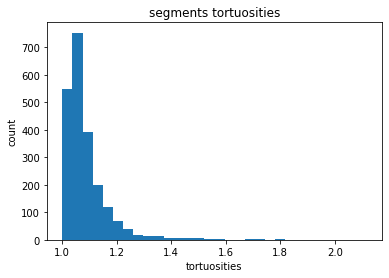

In [32]:
tortuosities = [edge['tortuosity'] for edge in dag.edges]
plt.title('segments tortuosities')
plt.hist(tortuosities, bins=30)

plt.xlabel('tortuosities')
plt.ylabel('count')
plt.show()

## Volume filled with vascular structure

In [33]:
print(dag['vascular_structure_volume'])

392146


## Fractal dimention

In [34]:
print(dag['fractal_dimension'])

1.6273605145729009


## Mean interstitial distance to the nearest vessel

In [37]:
visualization = np.zeros(dag.volume_shape)
visualization = draw_edges(visualization, dag.edges, value='interstitial_distance')
visualize_gradient(visualization)

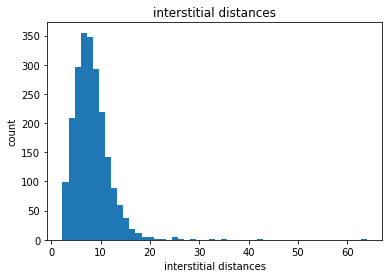

In [38]:
angles = [edge['interstitial_distance'] for edge in dag.edges[1:]]
plt.title('interstitial distances')
plt.hist(angles, bins=50)

plt.xlabel('interstitial distances')
plt.ylabel('count')
plt.show()

## Area covered by vascular network (overall size)

In [39]:
print(dag['vascular_network_projection_area'])

63520


## Vascular density

In [40]:
print('area covered by vascular network', dag['vascular_network_projection_area'])
print('area covered by networks explant', dag['projection_explant_area'])
print('vascular density', dag['vascular_density'])

area covered by vascular network 63520
area covered by networks explant 180867
vascular density 0.3511972886153914


## Lacunarity

In [41]:
print('Lacunarity is', dag['lacunarity'], '(average for boxes with sizes 10, 30, 50, 70, 90, 110, 130, 150)')

Lacunarity is 1.5020559959491009 (average for boxes with sizes 10, 30, 50, 70, 90, 110, 130, 150)


## Branching index - measurement of sprouting activity

In [42]:
print('Branching index is', dag['branchings_points_per_pixel'], 'branches per pixel')

Branching index is 0.01623110831234257 branches per pixel


## Statistics by generation TODO (to na dole jest zle, trzeba pokazac ciekawsze staty w zaleznosci od generacji)

In [14]:
def get_thiccness_by_generation(root): ## not using generations
    def populate_thiccness_dict(node, thiccness_dict, generation):
        thiccness_list = thiccness_dict.get(generation, [])
        thiccness_dict[generation] = thiccness_list + [node['thiccness']]
        
        for e in node.edges:
            populate_thiccness_dict(e.node_b, thiccness_dict, generation + 1)
            
    thiccness_dict = {}
    populate_thiccness_dict(root, thiccness_dict, 1)
    
    return thiccness_dict

In [15]:
thiccness_dict = get_thiccness_by_generation(dag.root)

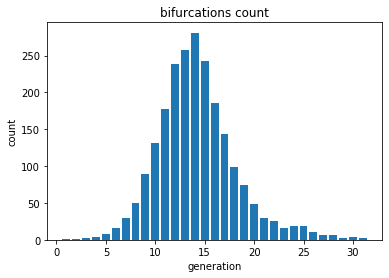

In [16]:
nodes_count = [len(v) for v in thiccness_dict.values()]  ## not using generations
generation_indices = list(thiccness_dict.keys())

plt.bar(generation_indices, height=nodes_count)
plt.title('bifurcations count')

plt.xlabel('generation')
plt.ylabel('count')
plt.show()

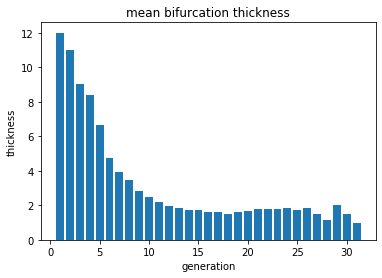

In [17]:
mean_thiccness = [np.mean(v) for v in thiccness_dict.values()]  ## not using generations
generation_indices = list(thiccness_dict.keys())

plt.bar(generation_indices, height=mean_thiccness)
plt.title('mean bifurcation thickness')

plt.xlabel('generation')
plt.ylabel('thickness')
plt.show()

In [18]:
np.unique([len(n.edges) for n in dag.nodes], return_counts=True)

(array([0, 1, 2, 3, 4]), array([1181,    1,  918,  107,   16]))

## Statistics comparisons TODO

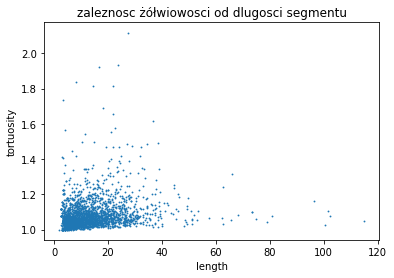

In [19]:
lengths = [edge['length'] for edge in dag.edges]
tortuosities = [edge['tortuosity'] for edge in dag.edges]
plt.title('zaleznosc żółwiowosci od dlugosci segmentu')
plt.scatter(lengths, tortuosities, s=0.7)

plt.xlabel('length')
plt.ylabel('tortuosity')
plt.show()

### edges statistics dataframe

In [20]:
stats = ['length', 'mean_thiccness', 'relative_angle', 'tortuosity']

df_dict = {}
for stat_name in stats:
    stat = [edge[stat_name] for edge in dag.edges]
    df_dict[stat_name] = stat
    
edges_stats_df = pd.DataFrame.from_dict(df_dict)
edges_stats_df.head()

,length,mean_thiccness,relative_angle,tortuosity
0,18.641729,11.461538,NaN,1.086592
1,101.738807,11.234568,1.411441,1.105494
2,78.921002,9.169492,1.161281,1.044866
3,22.044067,8.937500,1.056009,1.050910
4,14.312410,7.100000,0.853091,1.024933


In [21]:
corr = edges_stats_df.corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(3)

,length,mean_thiccness,relative_angle,tortuosity
length,1.000,0.208,-0.023,0.179
mean_thiccness,0.208,1.000,-0.015,-0.105
relative_angle,-0.023,-0.015,1.000,0.213
tortuosity,0.179,-0.105,0.213,1.000


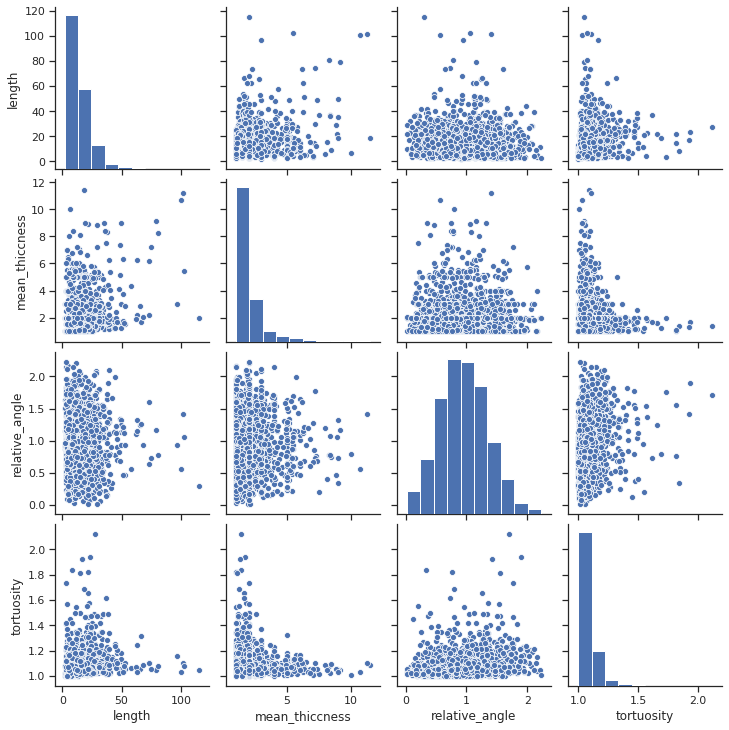

In [22]:
sns.set(style="ticks", color_codes=True)
g = sns.pairplot(edges_stats_df)